## Simple Recursive Feature Elimination Notebook 

This code uses LGBMClassifier, since RFECV works with that (and not with vanilla LightGBM)

References:
- https://www.kaggle.com/tilii7/recursive-feature-elimination/code
- https://www.kaggle.com/tilii7/features-we-don-t-need-no-stinking-features
- https://www.kaggle.com/nroman/recursive-feature-elimination

In [2]:
import os
import sys

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

import lightgbm as lgb

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score

pd.options.display.max_rows = 1000

In [3]:
sys.path.insert(0, "/opt/vssexclude/personal/kaggle/kaggle_tab_mar/src")

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import munging.process_data_util as process_data
import common.com_util as common
import config.constants as constants
import modeling.train_util as model

In [6]:
SEED = 42
TARGET = 'target'

LOGGER_NAME = 'main'
logger = common.get_logger(LOGGER_NAME)
common.set_seed(SEED)

In [7]:
train_df, test_df, sample_submission_df = process_data.read_processed_data(
    logger, constants.PROCESSED_DATA_DIR, train=True, test=True, sample_submission=True, frac=0.1)

[INFO]2021-03-23 10:29:41,719:main:Reading Data from /opt/vssexclude/personal/kaggle/kaggle_tab_mar/data/processed...
[INFO]2021-03-23 10:29:41,875:main:Shape of train_df : (30000, 31)
[INFO]2021-03-23 10:29:41,925:main:Shape of test_df : (20000, 30)
[INFO]2021-03-23 10:29:41,938:main:Shape of sample_submission_df : (20000, 1)


In [11]:
combined_df = pd.concat([train_df.drop('target', axis=1), test_df])
target = train_df[TARGET]

cat_fetaures = [name for name in train_df.columns if "cat" in name]

logger.info("Label Encoding the categorcal features")
for name in cat_fetaures:
    lb = LabelEncoder()
    combined_df[name] = lb.fit_transform(combined_df[name])

train_df = combined_df.loc[train_df.index]
train_df[TARGET] = target

test_df = combined_df.loc[test_df.index]

train_X = train_df.drop([TARGET], axis=1)
train_Y = train_df[TARGET]
test_X = test_df

[INFO]2021-03-23 10:31:00,574:main:Label Encoding the categorcal features


In [12]:
features = train_X.columns

In [13]:
MODEL_TYPE = "lgb"
OBJECTIVE = "binary"
BOOSTING_TYPE = "gbdt"
METRIC = "auc"
VERBOSE = 100
N_THREADS = -1
NUM_LEAVES = 31
MAX_DEPTH = -1
N_ESTIMATORS = 10000
LEARNING_RATE = 0.1
EARLY_STOPPING_ROUNDS = 100


lgb_params = {
                'objective': OBJECTIVE,
                'boosting_type': BOOSTING_TYPE,
                'learning_rate': LEARNING_RATE,
                'num_leaves': NUM_LEAVES,
                'tree_learner': 'serial',
                'n_jobs': N_THREADS,
                'seed': SEED,
                'max_depth': MAX_DEPTH,
                'max_bin': 255,
                'metric': METRIC,
                'verbose': -1,
                'n_estimators': N_ESTIMATORS
                }

model = lgb.LGBMClassifier(**lgb_params)

In [14]:
rfecv = RFECV(estimator=model,
              step=2,
              cv=StratifiedKFold(
                       n_splits=2,
                       shuffle=False),
              scoring=make_scorer(score_func=roc_auc_score),
              verbose=10)

In [15]:
rfecv.fit(train_X, train_Y)

Fitting estimator with 30 features.
Fitting estimator with 28 features.
Fitting estimator with 26 features.
Fitting estimator with 24 features.
Fitting estimator with 22 features.
Fitting estimator with 20 features.
Fitting estimator with 18 features.
Fitting estimator with 16 features.
Fitting estimator with 14 features.
Fitting estimator with 12 features.
Fitting estimator with 10 features.
Fitting estimator with 8 features.
Fitting estimator with 6 features.
Fitting estimator with 4 features.
Fitting estimator with 2 features.
Fitting estimator with 30 features.
Fitting estimator with 28 features.
Fitting estimator with 26 features.
Fitting estimator with 24 features.
Fitting estimator with 22 features.
Fitting estimator with 20 features.
Fitting estimator with 18 features.
Fitting estimator with 16 features.
Fitting estimator with 14 features.
Fitting estimator with 12 features.
Fitting estimator with 10 features.
Fitting estimator with 8 features.
Fitting estimator with 6 features

RFECV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
      estimator=LGBMClassifier(max_bin=255, metric='auc', n_estimators=10000,
                               objective='binary', seed=42,
                               tree_learner='serial', verbose=-1),
      scoring=make_scorer(roc_auc_score), step=2, verbose=10)

In [18]:
# How many features were selected?
print('Optimal number of features:', rfecv.n_features_)

Optimal number of features: 28


In [19]:
# What are the selected features
selected_features = list(train_X.loc[:, rfecv.get_support()].columns)
selected_features

['cat0',
 'cat1',
 'cat2',
 'cat3',
 'cat4',
 'cat5',
 'cat6',
 'cat7',
 'cat8',
 'cat9',
 'cat10',
 'cat11',
 'cat14',
 'cat15',
 'cat16',
 'cat17',
 'cat18',
 'cont0',
 'cont1',
 'cont2',
 'cont3',
 'cont4',
 'cont5',
 'cont6',
 'cont7',
 'cont8',
 'cont9',
 'cont10']

In [20]:
# What are the dropped features
dropped_features = set(train_X.columns) - set(selected_features)
dropped_features

{'cat12', 'cat13'}

### Plot number of features vs CV scores

I am not sure what does it show. Number of optimal features is 28, but this plot shows only 16 features.

As per the documentation:

> The size of grid_scores_ is equal to ceil((n_features - min_features_to_select) / step) + 1, where step is the number of features removed at each iteration.


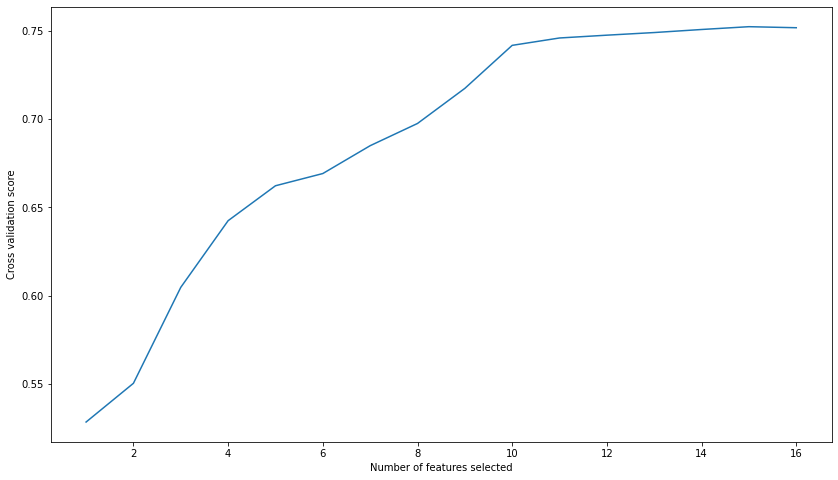

In [21]:
plt.figure(figsize=(14, 8))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

### All features with Rank 1 should be considered
There were two features which were dropped. Below DF shows that those two features are of rank 2.

In [23]:
# Save sorted feature rankings
ranking = pd.DataFrame({'feature': features})
ranking['rank'] = rfecv.ranking_
ranking = ranking.sort_values(['rank'], )
ranking

,feature,rank
0,cat0,1
27,cont8,1
26,cont7,1
25,cont6,1
24,cont5,1
23,cont4,1
22,cont3,1
21,cont2,1
20,cont1,1
19,cont0,1


### Make a prediction

In [26]:
# Highest Score
score = round(np.max(rfecv.grid_scores_), 5)
score

0.75242

In [35]:
predictions = rfecv.predict_proba(test_X)[:, -1]

sample_submission_df.target = predictions

sample_submission_df.head()

In [ ]:
# score = round(-np.max(rfecv.grid_scores_), 3)
# test['loss'] = rfecv.predict(Xt)
# test = test[['id', 'loss']]
# now = datetime.now()
# sub_file = 'submission_5xRFECV-RandomForest_' + str(score) + '_' + str(
#     now.strftime("%Y-%m-%d-%H-%M")) + '.csv'
# print("\n Writing submission file: %s" % sub_file)
# test.to_csv(sub_file, index=False)